# 0. Imports

## 0.1. Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn import preprocessing as pp
from sklearn import metrics as m
from plotly import express as px
import umap.umap_ as umap
from IPython.display import HTML
from pandas_profiling import ProfileReport
from sklearn import decomposition as dd
from sklearn.manifold import TSNE
from sklearn import ensemble as en

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
viridis0 = sns.color_palette(sns.color_palette('viridis', 5)[0], as_cmap=True)
viridis1 = sns.color_palette(sns.color_palette('viridis', 5)[2], as_cmap=True)
viridis2 = sns.color_palette(sns.color_palette('viridis', 5)[4], as_cmap=True)
simple_viridis = sns.set_palette([viridis0,viridis1,viridis2])

## 0.2. Helper Functions

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3. Load Dataset

In [5]:
df = pd.read_csv('../data/CC GENERAL.csv')

In [6]:
df.sample().T

,1764
CUST_ID,C11824
BALANCE,144.346693
BALANCE_FREQUENCY,1.0
PURCHASES,1976.32
ONEOFF_PURCHASES,859.79
INSTALLMENTS_PURCHASES,1116.53
CASH_ADVANCE,0.0
PURCHASES_FREQUENCY,1.0
ONEOFF_PURCHASES_FREQUENCY,0.25
PURCHASES_INSTALLMENTS_FREQUENCY,0.916667


# 1. Data Description

In [7]:
df1 = df.copy()

## 1.1. Rename Columns

In [8]:
df1.columns = list(map(lambda x: x.lower(), df1.columns))

## 1.2. Data Dimensions

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 8950
Number of columns: 18


## 1.3. Data Types

In [10]:
df1.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

cust_id                               0
balance                               0
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                          0
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    313
prc_full_payment                      0
tenure                                0
dtype: int64

## 1.5. Replace NA

In [12]:
# Replacing credit_limit variable
df1['credit_limit'].fillna(df1['credit_limit'].min(),inplace=True)

# Replacing minimum_payments variable
df1['minimum_payments'].fillna(0,inplace=True)

## 1.6. Change dtypes

In [13]:
df1['cust_id'] = df1['cust_id'].map(lambda x: x[1:]).astype(int)

## 1.7. Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [15]:
# Central Tendency -> Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion -> Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
metrics = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
metrics.columns = ['Attributes','Min','Max','Range','Mean','Median','Std','Skew','Kurtosis']
metrics

,Attributes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,balance,0.0,19043.13856,19043.13856,1564.474828,873.385231,2081.415590,2.393386,7.674751
1,balance_frequency,0.0,1.00000,1.00000,0.877271,1.000000,0.236891,-2.023266,3.092370
2,purchases,0.0,49039.57000,49039.57000,1003.204834,361.280000,2136.515413,8.144269,111.388771
3,oneoff_purchases,0.0,40761.25000,40761.25000,592.437371,38.000000,1659.795184,10.045083,164.187572
4,installments_purchases,0.0,22500.00000,22500.00000,411.067645,89.000000,904.287592,7.299120,96.575178
5,cash_advance,0.0,47137.21176,47137.21176,978.871112,0.000000,2097.046713,5.166609,52.899434
6,purchases_frequency,0.0,1.00000,1.00000,0.490351,0.500000,0.401348,0.060164,-1.638631
7,oneoff_purchases_frequency,0.0,1.00000,1.00000,0.202458,0.083333,0.298319,1.535613,1.161846
8,purchases_installments_frequency,0.0,1.00000,1.00000,0.364437,0.166667,0.397426,0.509201,-1.398632
9,cash_advance_frequency,0.0,1.50000,1.50000,0.135144,0.000000,0.200110,1.828686,3.334734


# 2. Feature Filtering

In [16]:
df2 = df1.copy()

In [149]:
# Filtering three lines that put number of transactions equal to 0 and transaction value different from 0;
df2 = df2[~((df1['purchases_trx']==0) & (df1['purchases']!=0))]

# Filtering two lines that put number of transactions different from 0 and transaction value equal to 0;
df2 = df2[~((df1['purchases_trx']!=0) & (df1['purchases']==0))]

# Filtering the single line where purchases and cash_advance are zero;
df2 = df2[~((df2['purchases']==0) & (df2['cash_advance']==0))]

# Filtering the eight lines where cash_advance_frequency is greater than 1;
df2 = df2[~(df2['cash_advance_frequency']>1)]

# Filtering the 18 lines where purchases variable doesn't match the sum of oneoff_purchases and installments_purchases
df2 = df2[~(abs(df2['purchases'] - (df2['oneoff_purchases'] + df2['installments_purchases'])) > 1)]

# 3. Feature Engineering

In [150]:
df3 = df2.copy()

In [151]:
df3['purchases_avg'] = df3[['purchases','purchases_trx']].apply(lambda x: x['purchases']/x['purchases_trx'] if x['purchases']!=0 else 0,axis=1)
df3['cash_advance_avg'] = df3[['cash_advance','cash_advance_trx']].apply(lambda x: x['cash_advance']/x['cash_advance_trx'] if x['cash_advance']!=0 else 0,axis=1)

## 3.1. Feature Creation

In [152]:
df3.sample(5).T

,4781,2850,7493,8179,297
cust_id,14915.000000,12932.000000,17696.000000,18399.000000,10308.000000
balance,0.000000,67.860540,74.430900,147.146710,5547.092593
balance_frequency,0.000000,0.363636,1.000000,1.000000,1.000000
purchases,581.000000,295.640000,45.650000,356.680000,0.000000
oneoff_purchases,0.000000,189.000000,45.650000,0.000000,0.000000
installments_purchases,581.000000,106.640000,0.000000,356.680000,0.000000
cash_advance,0.000000,0.000000,0.000000,0.000000,3298.958165
purchases_frequency,0.583333,0.666667,0.083333,1.000000,0.000000
oneoff_purchases_frequency,0.000000,0.083333,0.083333,0.000000,0.000000
purchases_installments_frequency,0.583333,0.666667,0.000000,1.000000,0.000000


In [153]:
df_ref = df3[['cust_id',
              'oneoff_purchases',
              'installments_purchases',
              'cash_advance',
              'oneoff_purchases_frequency',
              'purchases_installments_frequency',
              'cash_advance_frequency',
              'purchases_trx',
              'cash_advance_trx']].copy()

df_ref.sample(5).T

,5689,4583,4249,4855,6303
cust_id,15847.000000,14709.000000,14367.000000,14989.000000,16478.000000
oneoff_purchases,0.000000,0.000000,0.000000,0.000000,216.920000
installments_purchases,277.330000,0.000000,0.000000,272.340000,1614.990000
cash_advance,0.000000,482.992567,3500.334072,0.000000,0.000000
oneoff_purchases_frequency,0.000000,0.000000,0.000000,0.000000,0.083333
purchases_installments_frequency,0.916667,0.000000,0.000000,0.416667,0.750000
cash_advance_frequency,0.000000,0.083333,0.333333,0.000000,0.000000
purchases_trx,17.000000,0.000000,0.000000,8.000000,19.000000
cash_advance_trx,0.000000,1.000000,21.000000,0.000000,0.000000


# 4. EDA (Exploratory Data Analysis)

In [154]:
df4 = df3.copy()

## 4.1. Univariate Analysis

**Notes:**
1. Clusters should be Cohesive (closely united) and Separate (away one from another)
2. Metrics:
    - Min, Max, Range (Dispersion);
    - Mean and Median;
    - Standard Deviation and Variation;
    - Coefficient of Variation (CV);
    - Distribution;

In [123]:
#profile = ProfileReport(df4)
#profile.to_file('../eda/univariate_analysis.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.1.1. balance

In [115]:
n = df4[df4['balance']>df4['credit_limit']].shape[0]
print(f'{n}  clients have a balance greater than their credit limit, this represents {round(n/df4.shape[0]*100,2)}% from database.')

226  clients have a balance greater than their credit limit, this represents 2.53% of the database.


In [116]:
df4['diff'] = df4['balance'] - df4['credit_limit']

df4.sort_values('diff',ascending=False).head()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,purchases_avg,cash_advance_avg,diff
4376,14499,10571.411070,1.0,7739.48,0.00,7739.48,0.000,1.00,0.000000,1.000000,0.000000,0,44,8000.0,2688.447014,76406.20752,0.0,12,175.897273,0.000000,2571.411070
567,10591,3457.086184,1.0,2448.60,0.00,2448.60,0.000,1.00,0.000000,1.000000,0.000000,0,12,1700.0,227.514473,38512.12477,0.0,12,204.050000,0.000000,1757.086184
1012,11047,12373.333480,1.0,830.15,200.00,630.15,10249.921,0.75,0.166667,0.583333,0.916667,26,14,11000.0,14040.866350,12245.92601,0.0,12,59.296429,394.227731,1373.333480
138,10144,19043.138560,1.0,22009.92,9449.07,12560.85,0.000,1.00,0.750000,1.000000,0.000000,0,216,18000.0,23018.575830,18621.01331,0.0,12,101.897778,0.000000,1043.138560
4086,14202,6832.111113,1.0,6508.08,0.00,6508.08,0.000,1.00,0.000000,1.000000,0.000000,0,72,6000.0,8210.115891,13621.70839,0.0,12,90.390000,0.000000,832.111113


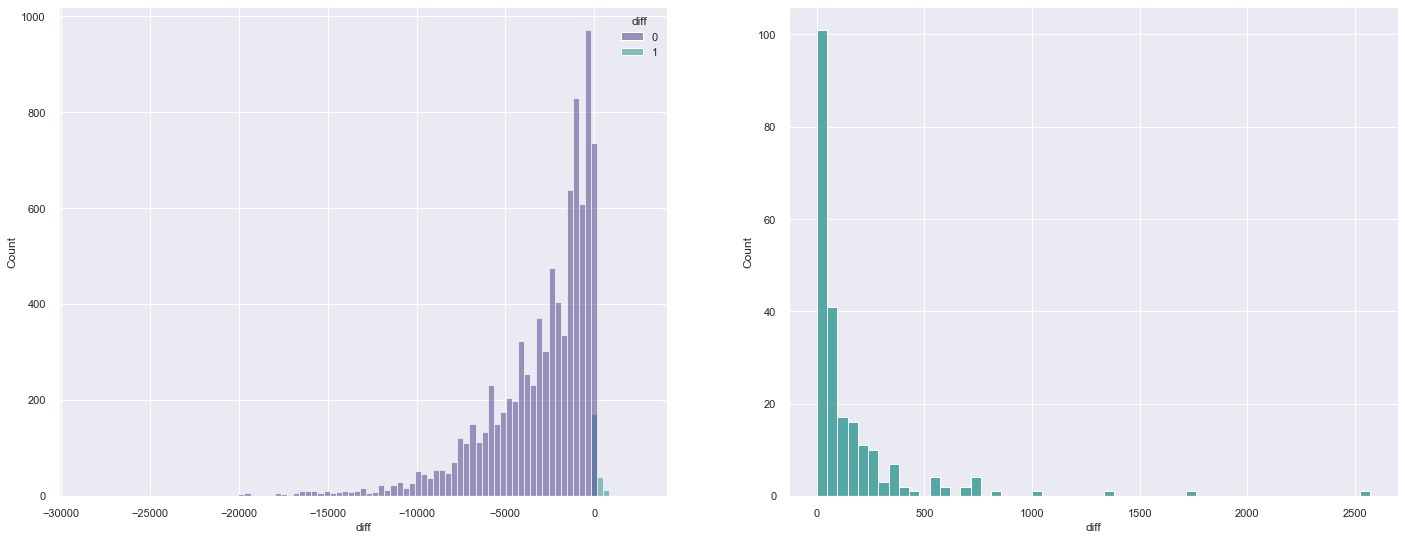

In [117]:
# Histplot of cases that have balance over credit_limit
plt.subplot(1,2,1)
sns.histplot(x=df4['diff'],hue=df4['diff'].map(lambda x: 1 if x>0 else 0),palette = sns.set_palette([viridis0,viridis1]));

plt.subplot(1,2,2)
sns.histplot(df4[df4['diff']>0]['diff'],color=viridis1);

In [118]:
df4.drop('diff',axis=1,inplace=True)

### 4.1.2. balance_frequency

In [119]:
n = df4[df4['balance_frequency']==1].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% from database are classified with balance_frequency = 1, which is the maximum value.')

6189 customers that represents 69.38% of the database are classified with balance_frequency = 1, which is the maximum value.


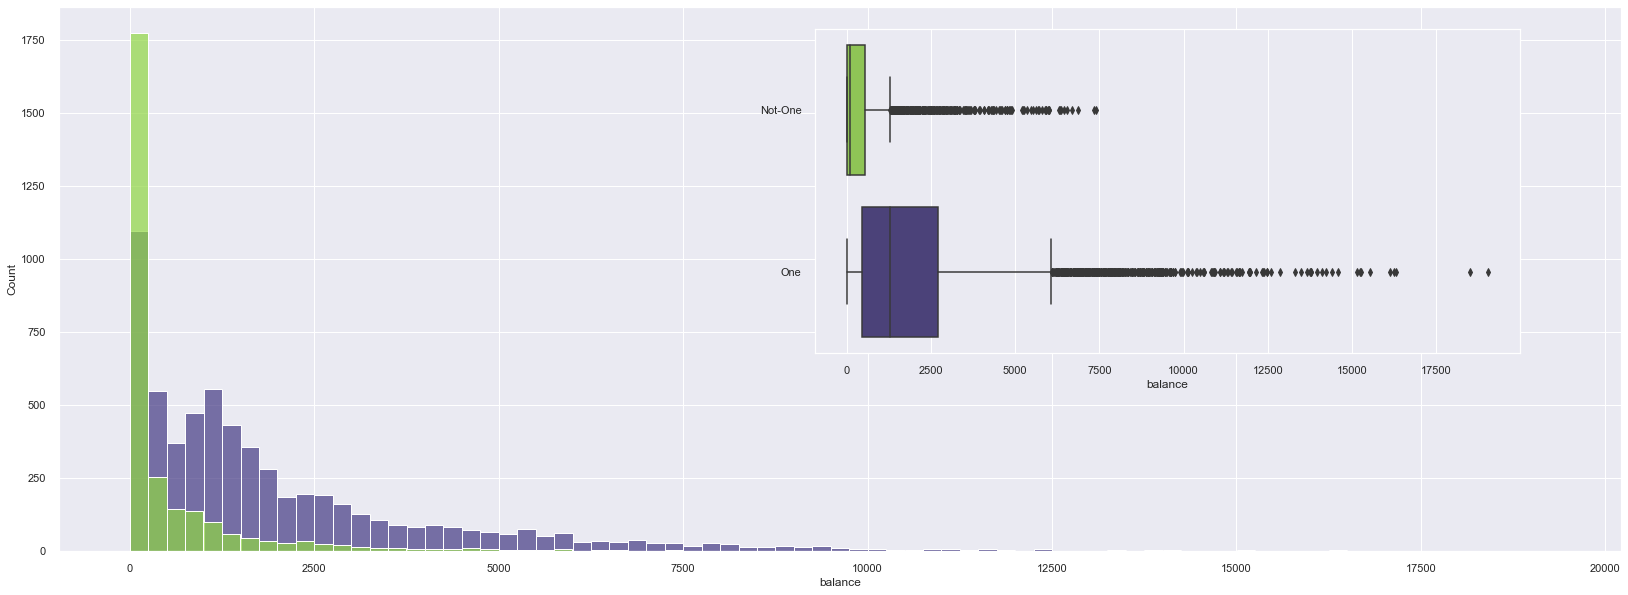

In [120]:
fig = plt.figure(figsize=(28,10))

sns.histplot(df4[df4['balance_frequency']==1]['balance'],color=viridis0,binwidth=250,alpha=.7);
sns.histplot(df4[df4['balance_frequency']!=1]['balance'],color=viridis2,binwidth=250,alpha=.7);

ax2 = fig.add_axes([.5,.4,.35,.45])

df4['bf1'] = df4['balance_frequency'].apply(lambda x: 'One' if x==1 else 'Not-One')
sns.boxplot(data=df4,x='balance',y='bf1',palette=sns.set_palette([viridis2,viridis0]),ax=ax2);
ax2.set_ylabel(' ');

In [121]:
df4.drop('bf1',axis=1,inplace=True)

### 4.1.3. purchases

In [173]:
n = df4[df4['purchases']==0].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% from database spent $0 in the last 6 months.')

2036 customers that represents 22.83% from database spent $0 in the last 6 months.


In [174]:
n1 = df4['purchases'].quantile(.99)
n2 = df4['purchases'].max()
print(f'Only 1% of  the customers from the database spent more than ${round(n1,2)}, being ${n2} the maximum amount spent.')

Only 1% of  the customers from the database spent more than $8997.13, being $49039.57 the maximum amount spent.


In [155]:
purchases_gb = df4.groupby(df4['purchases'].apply(lambda x: 'High' if x>df4['purchases'].quantile(.99) else
                                                            'Zero' if x==0 else
                                                            'Between'))

In [168]:
purchases_gb[['purchases','oneoff_purchases','installments_purchases']].agg(['min','mean','max']).T

purchases                        Between       High  Zero
purchases              min      0.010000   9007.670   0.0
                       mean  1112.313210  15637.641   0.0
                       max   8945.670000  49039.570   0.0
oneoff_purchases       min      0.000000      0.000   0.0
                       mean   634.965458  10930.790   0.0
                       max   8945.670000  40761.250   0.0
installments_purchases min      0.000000      0.000   0.0
                       mean   477.347752   4706.851   0.0
                       max   8391.550000  22500.000   0.0

In [159]:
purchases_gb[['purchases_frequency','oneoff_purchases_frequency','purchases_installments_frequency']].agg(['min','mean','max']).T

purchases                               Between      High  Zero
purchases_frequency              min   0.083333  0.166667   0.0
                                 mean  0.632255  0.905370   0.0
                                 max   1.000000  1.000000   0.0
oneoff_purchases_frequency       min   0.000000  0.000000   0.0
                                 mean  0.256397  0.756953   0.0
                                 max   1.000000  1.000000   0.0
purchases_installments_frequency min   0.000000  0.000000   0.0
                                 mean  0.468911  0.738434   0.0
                                 max   1.000000  1.000000   0.0

In [156]:
purchases_gb[['purchases_trx','purchases_avg']].agg(['min','mean','max']).T

purchases               Between         High  Zero
purchases_trx min      1.000000     3.000000   0.0
              mean    17.740135   120.555556   0.0
              max    309.000000   358.000000   0.0
purchases_avg min      0.010000    37.340714   0.0
              mean    92.504537   345.462596   0.0
              max   2900.000000  5981.666667   0.0

### 4.1.4. oneoff_purchases 

In [175]:
n = df4[df4['oneoff_purchases']==0].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% from database spent $0 on one-off in the last 6 months.')

4281 customers that represents 48.0% from database spent $0 on one-off in the last 6 months.


In [176]:
n1 = df4['oneoff_purchases'].quantile(.99)
n2 = df4['oneoff_purchases'].max()
print(f'Only 1% of  the customers from the database spent more than ${round(n1,2)} on one-off, being ${n2} the maximum amount spent.')

Only 1% of  the customers from the database spent more than $6697.2 on one-off, being $40761.25 the maximum amount spent.


In [164]:
one_off_purchases_gb = df4.groupby(df4['oneoff_purchases'].apply(lambda x: 'High' if x>df4['oneoff_purchases'].quantile(.99) else
                                                                           'Zero' if x==0 else
                                                                           'Between'))

In [169]:
one_off_purchases_gb[['purchases','oneoff_purchases','installments_purchases']].agg(['min','mean','max']).T

oneoff_purchases                  Between          High          Zero
purchases              min       0.010000   6814.470000      0.000000
                       mean   1417.972874  14577.338889    280.947407
                       max   15108.470000  49039.570000  22500.000000
oneoff_purchases       min       0.010000   6701.080000      0.000000
                       mean    922.293921  12253.178111      0.000000
                       max    6678.260000  40761.250000      0.000000
installments_purchases min       0.000000      0.000000      0.000000
                       mean    495.678953   2324.160778    280.947407
                       max   12738.470000  15497.190000  22500.000000

In [166]:
one_off_purchases_gb[['purchases_frequency','oneoff_purchases_frequency','purchases_installments_frequency']].agg(['min','mean','max']).T

oneoff_purchases                        Between      High      Zero
purchases_frequency              min   0.083333  0.166667  0.000000
                                 mean  0.601257  0.898721  0.364625
                                 max   1.000000  1.000000  1.000000
oneoff_purchases_frequency       min   0.083333  0.166667  0.000000
                                 mean  0.381199  0.847357  0.000000
                                 max   1.000000  1.000000  0.000000
purchases_installments_frequency min   0.000000  0.000000  0.000000
                                 mean  0.378122  0.585909  0.345538
                                 max   1.000000  1.000000  1.000000

In [167]:
one_off_purchases_gb[['purchases_trx','purchases_avg']].agg(['min','mean','max']).T

oneoff_purchases        Between         High         Zero
purchases_trx min      1.000000     3.000000     0.000000
              mean    21.109523    96.833333     6.223079
              max    309.000000   358.000000   347.000000
purchases_avg min      0.010000    38.653629     0.000000
              mean   112.457915   323.059451    27.788123
              max   2900.000000  5981.666667  1875.000000

### 4.1.5. installments_purchases

In [177]:
n = df4[df4['installments_purchases']==0].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% from database spent $0 on installments in the last 6 months.')

3902 customers that represents 43.75% from database spent $0 on installments in the last 6 months.


In [178]:
n1 = df4['installments_purchases'].quantile(.99)
n2 = df4['installments_purchases'].max()
print(f'Only 1% of  the customers from the database spent more than ${round(n1,2)} on installments, being ${n2} the maximum amount spent.')

Only 1% of  the customers from the database spent more than $3882.18 on installments, being $22500.0 the maximum amount spent.


In [179]:
installments_purchases_gb = df4.groupby(df4['installments_purchases'].apply(lambda x: 'High' if x>df4['installments_purchases'].quantile(.99) else
                                                                                      'Zero' if x==0 else
                                                                                      'Between'))

In [180]:
installments_purchases_gb[['purchases','oneoff_purchases','installments_purchases']].agg(['min','mean','max']).T

installments_purchases            Between          High          Zero
purchases              min       4.440000   3927.120000      0.000000
                       mean   1306.282873  11719.895556    377.416448
                       max   41050.400000  49039.570000  22101.780000
oneoff_purchases       min       0.000000      0.000000      0.000000
                       mean    680.917503   5217.532111    377.416448
                       max   40624.060000  40761.250000  22101.780000
installments_purchases min       1.950000   3885.450000      0.000000
                       mean    625.365369   6502.363444      0.000000
                       max    3866.190000  22500.000000      0.000000

In [181]:
installments_purchases_gb[['purchases_frequency','oneoff_purchases_frequency','purchases_installments_frequency']].agg(['min','mean','max']).T

installments_purchases                  Between      High      Zero
purchases_frequency              min   0.083333  0.333333  0.000000
                                 mean  0.749303  0.944175  0.153695
                                 max   1.000000  1.000000  1.000000
oneoff_purchases_frequency       min   0.000000  0.000000  0.000000
                                 mean  0.235866  0.534983  0.153652
                                 max   1.000000  1.000000  1.000000
purchases_installments_frequency min   0.083333  0.166667  0.000000
                                 mean  0.643528  0.903165  0.000000
                                 max   1.000000  1.000000  0.000000

In [182]:
installments_purchases_gb[['purchases_trx','purchases_avg']].agg(['min','mean','max']).T

installments_purchases      Between         High         Zero
purchases_trx min          1.000000     5.000000     0.000000
              mean        22.127081   100.544444     3.406971
              max        344.000000   358.000000   309.000000
purchases_avg min          1.000000    37.340714     0.000000
              mean        63.285402   214.710252    84.140090
              max       1500.000000  2523.438000  5981.666667

### 4.1.6. cash_advance

#### Outlier

In [183]:
# Cust_id=2159 appears to be an outlier
df4['cash_advance'].sort_values(ascending=False).head()

2159    47137.21176
1059    29282.10915
71      27296.48576
7254    26268.69989
7645    26194.04954
Name: cash_advance, dtype: float64

In [184]:
df4.sort_values('cash_advance',ascending=False).head()

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,purchases_avg,cash_advance_avg
2159,12226,10905.053810,1.000000,431.93,133.50,298.43,47137.21176,0.583333,0.250000,0.500000,1.000000,123,21,19600.0,39048.59762,5394.173671,0.000000,12,20.568095,383.229364
1059,11094,8823.284205,1.000000,3719.00,2293.18,1425.82,29282.10915,1.000000,0.750000,1.000000,0.416667,26,61,15500.0,28150.97869,7321.639932,0.083333,12,60.967213,1126.234967
71,10074,2990.422186,0.909091,4523.27,1664.09,2859.18,27296.48576,0.666667,0.500000,0.583333,0.833333,27,33,7000.0,28232.69446,1107.030803,0.454545,12,137.068788,1010.980954
7254,17450,4530.205197,1.000000,1750.66,643.18,1107.48,26268.69989,1.000000,0.333333,1.000000,0.583333,10,36,8500.0,25203.91336,1366.869273,0.250000,12,48.629444,2626.869989
7645,17851,7081.171387,1.000000,0.00,0.00,0.00,26194.04954,0.000000,0.000000,0.000000,0.909091,69,0,9000.0,20191.30770,1926.017588,0.222222,11,0.000000,379.623906


In [194]:
df4.sort_values('cash_advance_trx',ascending=False)['cash_advance'].head()

2159    47137.211760
542      5406.459348
8315    10458.978150
3545     9968.184827
1913     5603.126858
Name: cash_advance, dtype: float64

In [193]:
df4.sort_values('cash_advance_avg',ascending=False)['cash_advance'].head()

3908    14836.451410
2487    10590.411130
2682     9798.167329
637      9671.336737
2815     9553.955906
Name: cash_advance, dtype: float64

Cust_id=2159 performed the maximum cash_advance value found in the last 6 months, but it is still not in the top 5 cash_advance_avg list, furthermore its value is too far away from being on the list.
Because of this, it will be treated as a outlier

#### GroupBy Analysis

In [195]:
df4.columns

Index(['cust_id', 'balance', 'balance_frequency', 'purchases',
       'oneoff_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'oneoff_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment', 'tenure', 'purchases_avg',
       'cash_advance_avg'],
      dtype='object')

In [196]:
n = df4[df4['cash_advance']==0].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% did not perform any cash_advance in the last 6 months.')

4612 customers that represents 51.72% did not perform any cash_advance in the last 6 months.


In [197]:
n1 = df4['cash_advance'].quantile(.99)
n2 = df4['cash_advance'].max()
print(f'Only 1% of  the customers from the database perform more than ${round(n1,2)} on cash advance, being ${n2} the maximum amount.')

Only 1% of  the customers from the database perform more than $9593.49 on cash advance, being $47137.21176 the maximum amount.


In [198]:
cash_advance_gb = df4.groupby(df4['cash_advance'].apply(lambda x: 'High' if x>df4['cash_advance'].quantile(.99) else
                                                                  'Zero' if x==0 else
                                                                  'Between'))

In [201]:
cash_advance_gb[['cash_advance','cash_advance_frequency','cash_advance_trx','cash_advance_avg']].agg(['min','mean','max']).T

cash_advance                     Between          High  Zero
cash_advance           min     14.222216   9596.316702   0.0
                       mean  1773.164446  13859.316198   0.0
                       max   9579.677222  47137.211760   0.0
cash_advance_frequency min      0.083333      0.083333   0.0
                       mean     0.272039      0.571094   0.0
                       max      1.000000      1.000000   0.0
cash_advance_trx       min      1.000000      1.000000   0.0
                       mean     6.311907     25.266667   0.0
                       max    123.000000    123.000000   0.0
cash_advance_avg       min     14.222216     85.032343   0.0
                       mean   412.748882   1402.527239   0.0
                       max   9553.955906  14836.451410   0.0

### 4.1.7 purchases_frequency

In [207]:
n0 = df4[df4['purchases_frequency']==0].shape[0]
n1 = df4[df4['purchases_frequency']==1].shape[0]
print(f'{n0} customers were classified with purchases_frequency=0, which is the minimum value, this customers represents {round(n0/df4.shape[0]*100,2)}% of the database.')
print(f'{n1} customers were classified with purchases_frequency=1, which is the maximum value, this customers represents {round(n1/df4.shape[0]*100,2)}% of the database.')

2036 customers were classified with purchases_frequency=0, which is the minimum value, this customers represents 22.83% of the database.
2173 customers were classified with purchases_frequency=1, which is the maximum value, this customers represents 24.37% of the database.


In [208]:
purc_freq_gb = df4.groupby(df4['purchases_frequency'].apply(lambda x: 'Zero' if x==0 else
                                                                      'One' if x==1 else
                                                                      'Between'))

In [210]:
purc_freq_gb[['purchases_frequency','oneoff_purchases_frequency','purchases_installments_frequency']].agg(['min','mean','max']).T

purchases_frequency                     Between       One  Zero
purchases_frequency              min   0.083333  1.000000   0.0
                                 mean  0.467777  1.000000   0.0
                                 max   0.916667  1.000000   0.0
oneoff_purchases_frequency       min   0.000000  0.000000   0.0
                                 mean  0.200699  0.397829   0.0
                                 max   1.000000  1.000000   0.0
purchases_installments_frequency min   0.000000  0.000000   0.0
                                 mean  0.298310  0.849774   0.0
                                 max   1.000000  1.000000   0.0

In [211]:
purc_freq_gb[['purchases','oneoff_purchases','installments_purchases','purchases_trx']].agg(['min','mean','max']).T

purchases_frequency               Between           One  Zero
purchases              min       0.010000      8.400000   0.0
                       mean    870.787874   2237.311970   0.0
                       max   41050.400000  49039.570000   0.0
oneoff_purchases       min       0.000000      0.000000   0.0
                       mean    565.629382   1211.646447   0.0
                       max   40624.060000  40761.250000   0.0
installments_purchases min       0.000000      0.000000   0.0
                       mean    305.158492   1025.665522   0.0
                       max   22500.000000  15497.190000   0.0
purchases_trx          min       1.000000      6.000000   0.0
                       mean     10.579316     37.516337   0.0
                       max     309.000000    358.000000   0.0

### 4.1.8. oneoff_purchases_frequency

In [213]:
n0 = df4[df4['oneoff_purchases_frequency']==0].shape[0]
print(f'{n0} customers were classified with oneoff_purchases_frequency=0, which is the minimum value, this customers represents {round(n0/df4.shape[0]*100,2)}% of the database.')

4281 customers were classified with oneoff_purchases_frequency=0, which is the minimum value, this customers represents 48.0% of the database.


In [217]:
oo_purc_freq_gb = df4.groupby(df4['oneoff_purchases_frequency'].apply(lambda x: 'Zero' if x==0 else
                                                                                'Not Zero'))

In [218]:
oo_purc_freq_gb[['purchases_frequency','oneoff_purchases_frequency','purchases_installments_frequency']].agg(['min','mean','max']).T

oneoff_purchases_frequency             Not Zero      Zero
purchases_frequency              min   0.083333  0.000000
                                 mean  0.607030  0.364625
                                 max   1.000000  1.000000
oneoff_purchases_frequency       min   0.083333  0.000000
                                 mean  0.390247  0.000000
                                 max   1.000000  0.000000
purchases_installments_frequency min   0.000000  0.000000
                                 mean  0.382155  0.345538
                                 max   1.000000  1.000000

In [219]:
oo_purc_freq_gb[['purchases','oneoff_purchases','installments_purchases','purchases_trx']].agg(['min','mean','max']).T

oneoff_purchases_frequency       Not Zero          Zero
purchases              min       0.010000      0.000000
                       mean   1673.384335    280.947407
                       max   49039.570000  22500.000000
oneoff_purchases       min       0.010000      0.000000
                       mean   1142.216194      0.000000
                       max   40761.250000      0.000000
installments_purchases min       0.000000      0.000000
                       mean    531.168141    280.947407
                       max   15497.190000  22500.000000
purchases_trx          min       1.000000      0.000000
                       mean     22.579254      6.223079
                       max     358.000000    347.000000

### 4.1.9. purchases_installments_frequency

In [220]:
n0 = df4[df4['purchases_installments_frequency']==0].shape[0]
print(f'{n0} customers were classified with purchases_installments_frequency=0, which is the minimum value, this customers represents {round(n0/df4.shape[0]*100,2)}% of the database.')

3902 customers were classified with purchases_installments_frequency=0, which is the minimum value, this customers represents 43.75% of the database.


In [221]:
ins_purc_freq_gb = df4.groupby(df4['purchases_installments_frequency'].apply(lambda x: 'Zero' if x==0 else
                                                                                'Not Zero'))

In [222]:
ins_purc_freq_gb[['purchases_frequency','oneoff_purchases_frequency','purchases_installments_frequency']].agg(['min','mean','max']).T

purchases_installments_frequency       Not Zero      Zero
purchases_frequency              min   0.083333  0.000000
                                 mean  0.752800  0.153695
                                 max   1.000000  1.000000
oneoff_purchases_frequency       min   0.000000  0.000000
                                 mean  0.241233  0.153652
                                 max   1.000000  1.000000
purchases_installments_frequency min   0.083333  0.000000
                                 mean  0.648186  0.000000
                                 max   1.000000  0.000000

In [223]:
ins_purc_freq_gb[['purchases','oneoff_purchases','installments_purchases','purchases_trx']].agg(['min','mean','max']).T

purchases_installments_frequency      Not Zero          Zero
purchases              min            4.440000      0.000000
                       mean        1493.129990    377.416448
                       max        49039.570000  22101.780000
oneoff_purchases       min            0.000000      0.000000
                       mean         762.316091    377.416448
                       max        40761.250000  22101.780000
installments_purchases min            1.950000      0.000000
                       mean         730.813900      0.000000
                       max        22500.000000      0.000000
purchases_trx          min            1.000000      0.000000
                       mean          23.534091      3.406971
                       max          358.000000    309.000000

### 4.1.10. cash_advance_frequency

In [224]:
n0 = df4[df4['cash_advance_frequency']==0].shape[0]
print(f'{n0} customers were classified with cash_advance_frequency=0, which is the minimum value, this customers represents {round(n0/df4.shape[0]*100,2)}% of the database.')

4612 customers were classified with cash_advance_frequency=0, which is the minimum value, this customers represents 51.72% of the database.


In [225]:
cash_adv_freq_gb = df4.groupby(df4['cash_advance_frequency'].apply(lambda x: 'Zero' if x==0 else
                                                                             'Not Zero'))

In [227]:
cash_adv_freq_gb[['balance','cash_advance','cash_advance_trx','cash_advance_avg']].agg(['min','mean','max']).T

cash_advance_frequency      Not Zero          Zero
balance          min        0.000000      0.000000
                 mean    2386.856980    793.301553
                 max    16304.889250  19043.138560
cash_advance     min       14.222216      0.000000
                 mean    2025.777929      0.000000
                 max    47137.211760      0.000000
cash_advance_trx min        1.000000      0.000000
                 mean       6.708082      0.000000
                 max      123.000000      0.000000
cash_advance_avg min       14.222216      0.000000
                 mean     433.436307      0.000000
                 max    14836.451410      0.000000

### 4.1.11. cash_advance_trx

In [228]:
n = df4[df4['cash_advance_trx']==0].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% from database performed 0 cash advance transactions in the last 6 months.')

4612 customers that represents 51.72% from database performed 0 cash advance transactions in the last 6 months.


In [229]:
n1 = df4['cash_advance_trx'].quantile(.99)
n2 = df4['cash_advance_trx'].max()
print(f'Only 1% of  the customers from the database performed more than ${round(n1,2)} cash advance transactions, being ${n2} the maximum number of cash advance transactions made.')

Only 1% of  the customers from the database performed more than $29.0 cash advance transactions, being $123 the maximum number of cash advance transactions made.


In [230]:
cash_adv_trx_gb = df4.groupby(df4['cash_advance_trx'].apply(lambda x: 'High' if x>df4['cash_advance_trx'].quantile(.99) else
                                                                      'Zero' if x==0 else
                                                                      'Between'))

In [232]:
cash_adv_trx_gb[['balance','cash_advance','cash_advance_frequency','cash_advance_avg']].agg(['min','mean','max']).T

cash_advance_trx                  Between          High          Zero
balance                min       0.000000    168.600813      0.000000
                       mean   2346.694711   4289.826510    793.301553
                       max   16304.889250  14581.459140  19043.138560
cash_advance           min      14.222216   1244.774872      0.000000
                       mean   1905.548913   7722.471861      0.000000
                       max   29282.109150  47137.211760      0.000000
cash_advance_frequency min       0.083333      0.166667      0.000000
                       mean      0.267950      0.768200      0.000000
                       max       1.000000      1.000000      0.000000
cash_advance_avg       min      14.222216     40.154028      0.000000
                       mean    438.839999    177.398444      0.000000
                       max   14836.451410    755.525950      0.000000

### 4.1.12. purchases_trx

In [233]:
n = df4[df4['purchases_trx']==0].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% from database performed 0 purchases transactions in the last 6 months.')

2036 customers that represents 22.83% from database performed 0 purchases transactions in the last 6 months.


In [234]:
n1 = df4['purchases_trx'].quantile(.99)
n2 = df4['purchases_trx'].max()
print(f'Only 1% of  the customers from the database performed more than ${round(n1,2)} purchases transactions, being ${n2} the maximum number of purchases transactions made.')

Only 1% of  the customers from the database performed more than $116.83 purchases transactions, being $358 the maximum number of purchases transactions made.


In [235]:
purchases_trx_gb = df4.groupby(df4['purchases_trx'].apply(lambda x: 'High' if x>df4['purchases_trx'].quantile(.99) else
                                                                    'Zero' if x==0 else
                                                                    'Between'))

In [238]:
purchases_trx_gb[['purchases','oneoff_purchases','installments_purchases']].agg(['min','mean','max']).T

purchases_trx                     Between          High  Zero
purchases              min       0.010000    900.870000   0.0
                       mean   1189.012571   9849.395889   0.0
                       max   49039.570000  41050.400000   0.0
oneoff_purchases       min       0.000000      0.000000   0.0
                       mean    698.746294   6117.462889   0.0
                       max   40761.250000  40624.060000   0.0
installments_purchases min       0.000000      0.000000   0.0
                       mean    490.266277   3731.933000   0.0
                       max   22500.000000  15497.190000   0.0

In [237]:
purchases_trx_gb[['purchases_frequency','oneoff_purchases_frequency','purchases_installments_frequency']].agg(['min','mean','max']).T

purchases_trx                           Between      High  Zero
purchases_frequency              min   0.083333  0.363636   0.0
                                 mean  0.631279  0.979040   0.0
                                 max   1.000000  1.000000   0.0
oneoff_purchases_frequency       min   0.000000  0.000000   0.0
                                 mean  0.256768  0.728956   0.0
                                 max   1.000000  1.000000   0.0
purchases_installments_frequency min   0.000000  0.000000   0.0
                                 mean  0.466833  0.895286   0.0
                                 max   1.000000  1.000000   0.0

### 4.1.13. purchases_avg

In [239]:
n = df4[df4['purchases_avg']==0].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% from database has average purchases equal to 0 in the last 6 months.')

2036 customers that represents 22.83% from database has average purchases equal to 0 in the last 6 months.


In [241]:
n1 = df4['purchases_avg'].quantile(.99)
n2 = df4['purchases_avg'].max()
print(f'Only 1% of  the customers from the database has average purchases greater than ${round(n1,2)}, being ${round(n2,2)} the maximum average purchases.')

Only 1% of  the customers from the database has average purchases greater than $761.38, being $5981.67 the maximum average purchases.


In [249]:
avg_purchases_gb = df4.groupby(df4['purchases_avg'].apply(lambda x: 'High Spenders' if x>df4['purchases_avg'].quantile(.99) else
                                                                    'Zero' if x==0 else
                                                                    'Low Spenders'))

In [250]:
avg_purchases_gb[['purchases','oneoff_purchases','installments_purchases']].agg(['min','mean','max']).T

purchases_avg                High Spenders  Low Spenders  Zero
purchases              min      763.710000      0.010000   0.0
                       mean    3069.047889   1278.858171   0.0
                       max    26784.620000  49039.570000   0.0
oneoff_purchases       min        0.000000      0.000000   0.0
                       mean    2424.782778    747.677568   0.0
                       max    26514.320000  40761.250000   0.0
installments_purchases min        0.000000      0.000000   0.0
                       mean     644.265111    531.180604   0.0
                       max    22500.000000  15497.190000   0.0

In [251]:
avg_purchases_gb[['purchases_frequency','oneoff_purchases_frequency','purchases_installments_frequency']].agg(['min','mean','max']).T

purchases_avg                          High Spenders  Low Spenders  Zero
purchases_frequency              min        0.083333      0.083333   0.0
                                 mean       0.156818      0.642174   0.0
                                 max        0.750000      1.000000   0.0
oneoff_purchases_frequency       min        0.000000      0.000000   0.0
                                 mean       0.129967      0.264705   0.0
                                 max        0.750000      1.000000   0.0
purchases_installments_frequency min        0.000000      0.000000   0.0
                                 mean       0.025926      0.478352   0.0
                                 max        0.750000      1.000000   0.0

In [252]:
avg_purchases_gb[['purchases_trx','purchases_avg']].agg(['min','mean','max']).T

purchases_avg       High Spenders  Low Spenders  Zero
purchases_trx min        1.000000      1.000000   0.0
              mean       2.466667     19.304918   0.0
              max       33.000000    358.000000   0.0
purchases_avg min      763.710000      0.010000   0.0
              mean    1267.341731     80.288824   0.0
              max     5981.666667    750.000000   0.0

### 4.1.14. cash_advance_avg

In [253]:
n = df4[df4['cash_advance_avg']==0].shape[0]
print(f'{n} customers that represents {round(n/df4.shape[0]*100,2)}% from database has average cash advance equal to 0 in the last 6 months.')

4612 customers that represents 51.72% from database has average cash advance equal to 0 in the last 6 months.


In [254]:
n1 = df4['cash_advance_avg'].quantile(.99)
n2 = df4['cash_advance_avg'].max()
print(f'Only 1% of  the customers from the database has average cash advance greater than ${round(n1,2)}, being ${round(n2,2)} the maximum average cash advance.')

Only 1% of  the customers from the database has average cash advance greater than $1909.51, being $14836.45 the maximum average cash advance.


In [257]:
avg_cash_adv_gb = df4.groupby(df4['cash_advance_avg'].apply(lambda x: 'High Taker' if x>df4['cash_advance_avg'].quantile(.99) else
                                                                      'Zero' if x==0 else
                                                                      'Low Taker'))

In [258]:
avg_cash_adv_gb[['cash_advance','cash_advance_frequency','cash_advance_trx']].agg(['min','mean','max']).T

cash_advance_avg               High Taker     Low Taker  Zero
cash_advance           min    1909.684135     14.222216   0.0
                       mean   5275.877976   1956.397235   0.0
                       max   26268.699890  47137.211760   0.0
cash_advance_frequency min       0.083333      0.083333   0.0
                       mean      0.123097      0.281603   0.0
                       max       0.583333      1.000000   0.0
cash_advance_trx       min       1.000000      1.000000   0.0
                       mean      1.500000      6.819260   0.0
                       max      10.000000    123.000000   0.0

## 4.2. Data Space Study

In [65]:
df42 = df_ref.drop('cust_id',axis=1).copy()

In [66]:
mm = pp.MinMaxScaler()

In [67]:
for feature in df42.columns:
    df42[feature] = mm.fit_transform(df42[[feature]])
    
X = df42.copy()

In [68]:
df42.describe().T

,count,mean,std,min,25%,50%,75%,max
oneoff_purchases,8920.0,0.014567,0.040777,0.0,0.000000,0.000957,0.014254,1.0
installments_purchases,8920.0,0.018265,0.040158,0.0,0.000000,0.003964,0.020771,1.0
cash_advance,8920.0,0.020748,0.044498,0.0,0.000000,0.000000,0.023618,1.0
oneoff_purchases_frequency,8920.0,0.202867,0.298654,0.0,0.000000,0.083333,0.300000,1.0
purchases_installments_frequency,8920.0,0.364496,0.397458,0.0,0.000000,0.166667,0.750000,1.0
cash_advance_frequency,8920.0,0.134370,0.197745,0.0,0.000000,0.000000,0.222222,1.0
purchases_trx,8920.0,0.041130,0.069493,0.0,0.002793,0.019553,0.047486,1.0
cash_advance_trx,8920.0,0.026337,0.055406,0.0,0.000000,0.000000,0.032520,1.0


### 4.2.1. PCA

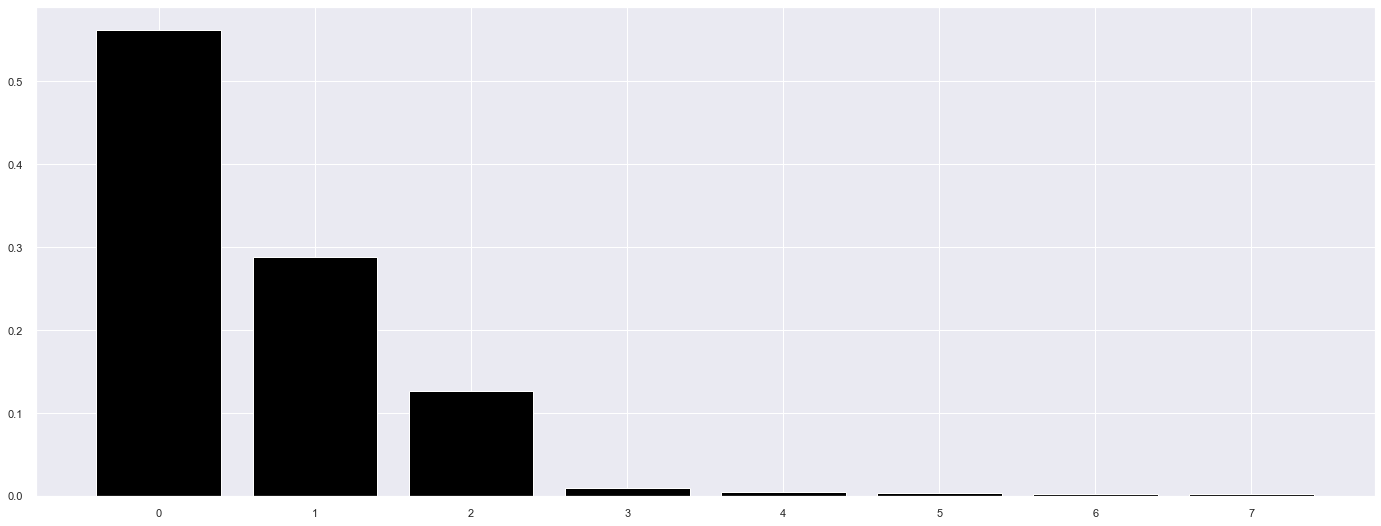

In [72]:
pca = dd.PCA( n_components=X.shape[1])

principal_components = pca.fit_transform( X )

# plot explained variable
features = range(pca.n_components_)
plt.bar(features,pca.explained_variance_ratio_,color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

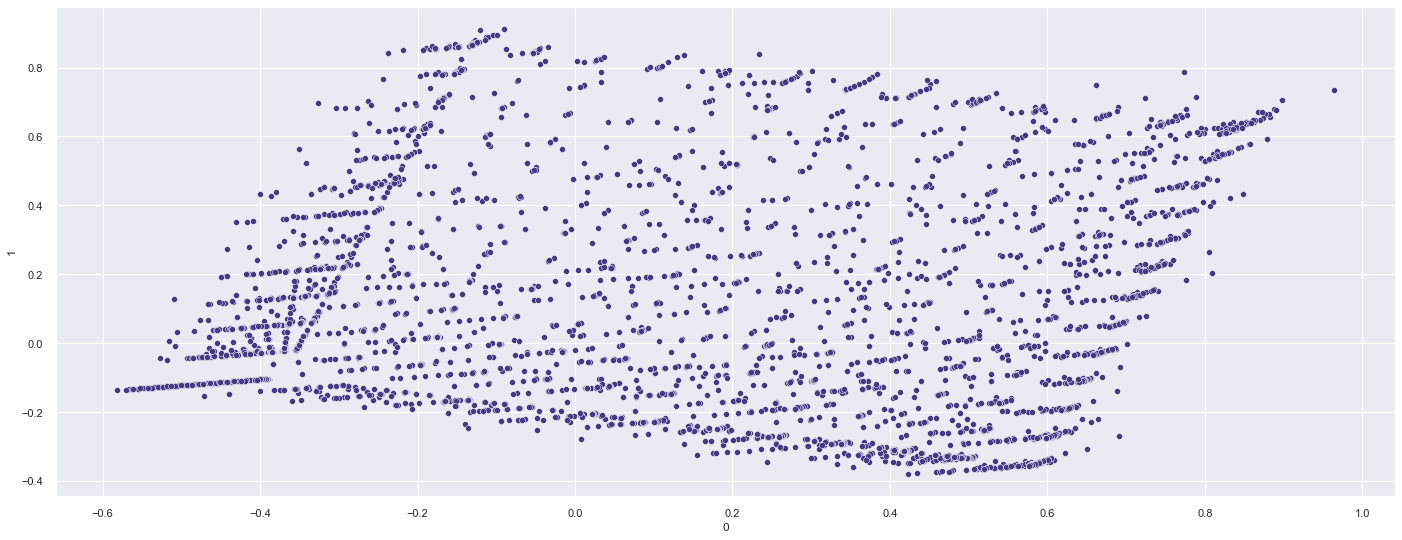

In [73]:
sns.scatterplot(x=0,y=1,data=df_pca)

### 4.2.2. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

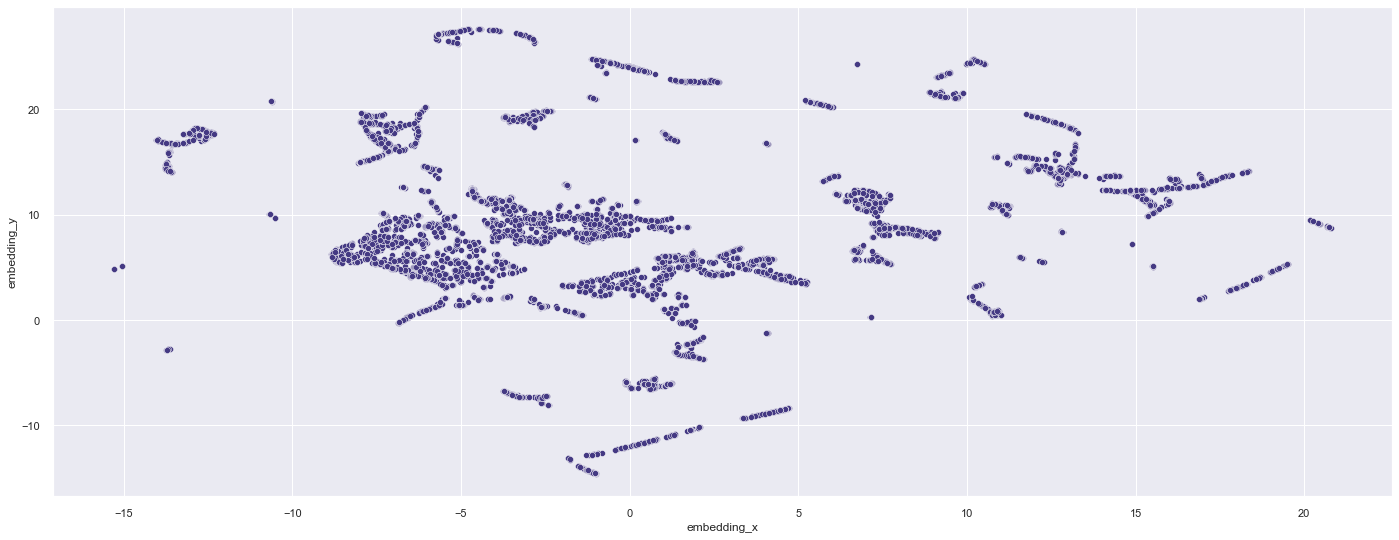

In [83]:
reducer = umap.UMAP(random_state=101)
embedding = reducer.fit_transform(X)

# embedding
df_umap = pd.DataFrame(embedding[:,0]).rename(columns={0:'embedding_x'})
df_umap['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x = 'embedding_x',
                y = 'embedding_y',
                data = df_umap)

### 4.2.3. t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

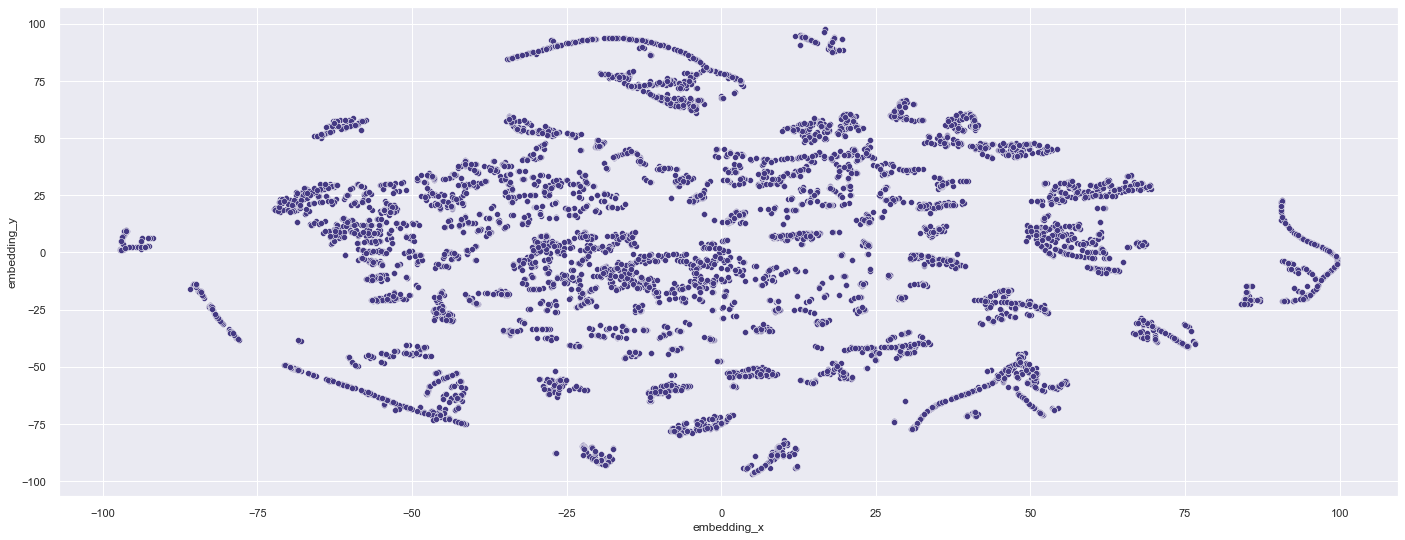

In [84]:
reducer = TSNE(n_components=2,
               n_jobs=-1,
               random_state=101)
embedding = reducer.fit_transform(X)

# embedding
df_tsne = pd.DataFrame(embedding[:,0]).rename(columns={0:'embedding_x'})
df_tsne['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x = 'embedding_x',
                y = 'embedding_y',
                data = df_tsne)

### 4.2.4. Tree-Based Embedding

In [121]:
# using 6 different variables as target to create the embedding space

# training dataset
X = df_ref.drop(['cust_id','cash_advance'],axis=1)
y= df_ref['cash_advance']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100,random_state=101)

# model training
rf_model.fit(X,y)

# creating leaf dataframe
df_leaf = pd.DataFrame(rf_model.apply(X))

# dimensionality reduzer
reducer = umap.UMAP(random_state=101)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_umap = pd.DataFrame(embedding[:,0]).rename(columns={0:'CA_embedding_x'})
df_umap['CA_embedding_y'] = embedding[:,1]        

In [122]:
# training dataset
X = df_ref.drop(['cust_id','cash_advance_frequency'],axis=1)
y= df_ref['cash_advance_frequency']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100,random_state=101)

# model training
rf_model.fit(X,y)

# creating leaf dataframe
df_leaf = pd.DataFrame(rf_model.apply(X))

# dimensionality reduzer
reducer = umap.UMAP(random_state=101)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_umap['CAF_embedding_x'] = embedding[:,0]        
df_umap['CAF_embedding_y'] = embedding[:,1]        

In [123]:
# training dataset
X = df_ref.drop(['cust_id','cash_advance_trx'],axis=1)
y= df_ref['cash_advance_trx']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100,random_state=101)

# model training
rf_model.fit(X,y)

# creating leaf dataframe
df_leaf = pd.DataFrame(rf_model.apply(X))

# dimensionality reduzer
reducer = umap.UMAP(random_state=101)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_umap['CAT_embedding_x'] = embedding[:,0]        
df_umap['CAT_embedding_y'] = embedding[:,1]        

In [126]:
# training dataset
X = df_ref.drop(['cust_id','installments_purchases'],axis=1)
y= df_ref['installments_purchases']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100,random_state=101)

# model training
rf_model.fit(X,y)

# creating leaf dataframe
df_leaf = pd.DataFrame(rf_model.apply(X))

# dimensionality reduzer
reducer = umap.UMAP(random_state=101)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_umap['IP_embedding_x'] = embedding[:,0]        
df_umap['IP_embedding_y'] = embedding[:,1] 

In [127]:
# training dataset
X = df_ref.drop(['cust_id','purchases_installments_frequency'],axis=1)
y= df_ref['purchases_installments_frequency']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100,random_state=101)

# model training
rf_model.fit(X,y)

# creating leaf dataframe
df_leaf = pd.DataFrame(rf_model.apply(X))

# dimensionality reduzer
reducer = umap.UMAP(random_state=101)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_umap['PIF_embedding_x'] = embedding[:,0]        
df_umap['PIF_embedding_y'] = embedding[:,1] 

In [128]:
# training dataset
X = df_ref.drop(['cust_id','purchases_trx'],axis=1)
y= df_ref['purchases_trx']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100,random_state=101)

# model training
rf_model.fit(X,y)

# creating leaf dataframe
df_leaf = pd.DataFrame(rf_model.apply(X))

# dimensionality reduzer
reducer = umap.UMAP(random_state=101)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_umap['PT_embedding_x'] = embedding[:,0]        
df_umap['PT_embedding_y'] = embedding[:,1]

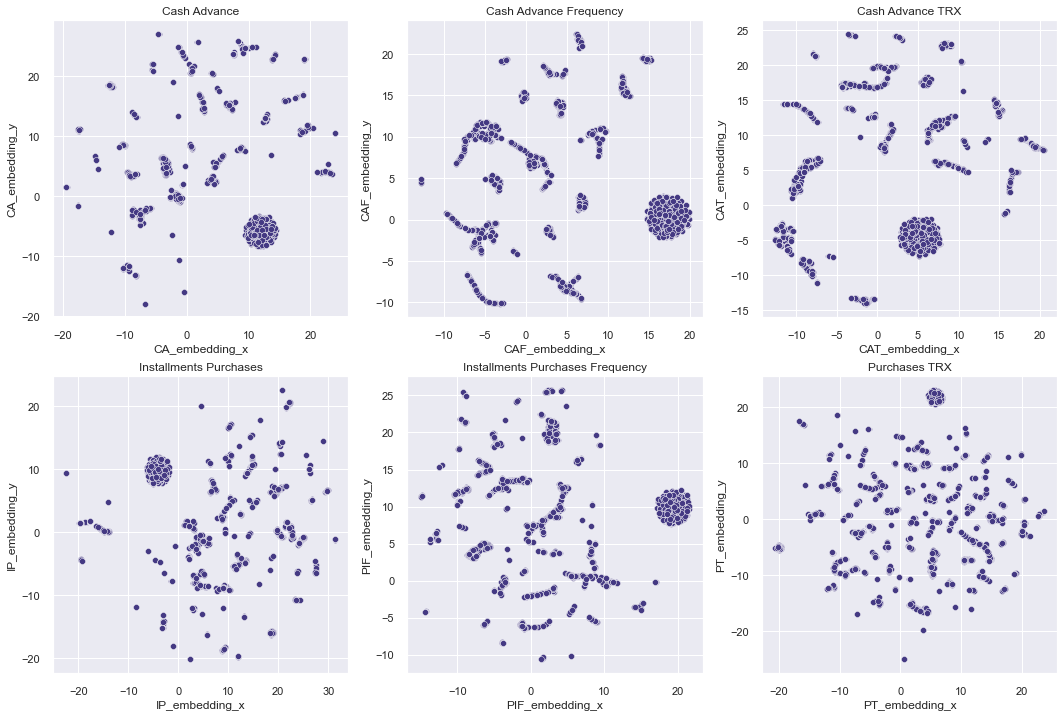

In [131]:
# plot UMAP
fig = plt.figure(figsize=(18,12))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

sns.scatterplot(x = 'CA_embedding_x',
                y = 'CA_embedding_y',
                data = df_umap,
                ax=ax1);
sns.scatterplot(x = 'CAF_embedding_x',
                y = 'CAF_embedding_y',
                data = df_umap,
                ax=ax2);
sns.scatterplot(x = 'CAT_embedding_x',
                y = 'CAT_embedding_y',
                data = df_umap,
                ax=ax3);
sns.scatterplot(x = 'IP_embedding_x',
                y = 'IP_embedding_y',
                data = df_umap,
                ax=ax4);
sns.scatterplot(x = 'PIF_embedding_x',
                y = 'PIF_embedding_y',
                data = df_umap,
                ax=ax5);
sns.scatterplot(x = 'PT_embedding_x',
                y = 'PT_embedding_y',
                data = df_umap,
                ax=ax6);



ax1.title.set_text('Cash Advance')
ax2.title.set_text('Cash Advance Frequency')
ax3.title.set_text('Cash Advance TRX')
ax4.title.set_text('Installments Purchases')
ax5.title.set_text('Installments Purchases Frequency')
ax6.title.set_text('Purchases TRX')
plt.show()

# 5. Data Preparation

In [132]:
df5 = df_ref.copy()

In [133]:
df5.head()

,cust_id,oneoff_purchases,installments_purchases,cash_advance,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,purchases_trx,cash_advance_trx
0,10001,0.00,95.4,0.000000,0.000000,0.083333,0.000000,2,0
1,10002,0.00,0.0,6442.945483,0.000000,0.000000,0.250000,0,4
2,10003,773.17,0.0,0.000000,1.000000,0.000000,0.000000,12,0
3,10004,1499.00,0.0,205.788017,0.083333,0.000000,0.083333,1,1
4,10005,16.00,0.0,0.000000,0.083333,0.000000,0.000000,1,0


In [134]:
## Standard Scaler
ss = pp.StandardScaler()

for feature in df5.columns[1:]:
    df5[feature] = ss.fit_transform(df5[[feature]])

In [135]:
df5.describe().T

,count,mean,std,min,25%,50%,75%,max
cust_id,8920.0,1.459967e+04,2651.620337,10001.000000,12306.750000,14596.500000,16900.250000,19190.000000
oneoff_purchases,8920.0,-4.288940e-15,1.000056,-0.357254,-0.357254,-0.333789,-0.007676,24.167488
installments_purchases,8920.0,-1.301662e-15,1.000056,-0.454853,-0.454853,-0.356148,0.062402,24.448292
cash_advance,8920.0,-4.366836e-17,1.000056,-0.466290,-0.466290,-0.466290,0.064497,22.007808
oneoff_purchases_frequency,8920.0,-1.443165e-15,1.000056,-0.679310,-0.679310,-0.400265,0.325254,2.669236
purchases_installments_frequency,8920.0,-1.864279e-15,1.000056,-0.917120,-0.917120,-0.497764,0.969980,1.599013
cash_advance_frequency,8920.0,-1.077290e-15,1.000056,-0.679549,-0.679549,-0.679549,0.444292,4.377740
purchases_trx,8920.0,-1.219571e-15,1.000056,-0.591900,-0.551702,-0.310515,0.091464,13.798933
cash_advance_trx,8920.0,1.196452e-15,1.000056,-0.475373,-0.475373,-0.475373,0.111605,17.574182


# 6. Feature Selection

In [50]:
df6 = df5.copy()

# 7. Hyperparameter Fine-Tunning

In [51]:
X = df6.drop('cust_id',axis=1)

In [52]:
clusters = [2,3,4,5,6,7,8,9]

In [53]:
model = KMeans(random_state=101)

## 7.1. Within-Cluster Sum of Square (WSS)

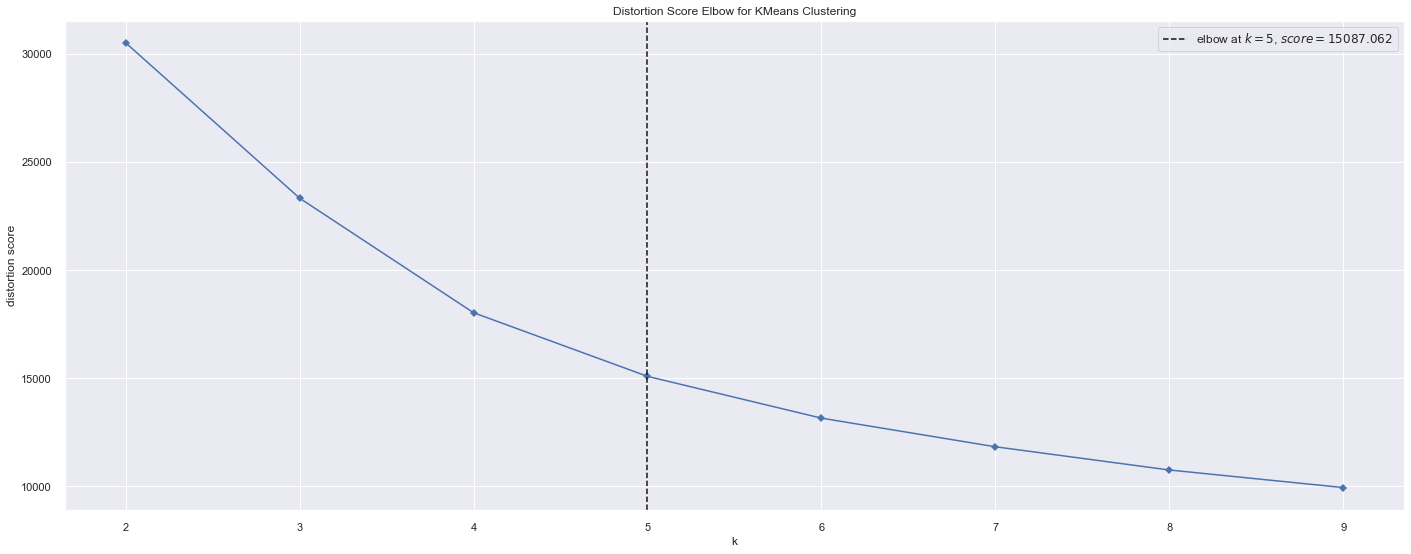

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [54]:
kmeans = KElbowVisualizer(model,k=clusters, metric='distortion',timings=False,random_state=101)
kmeans.fit(X)
kmeans.show()

## 7.2. Sillhouette Score

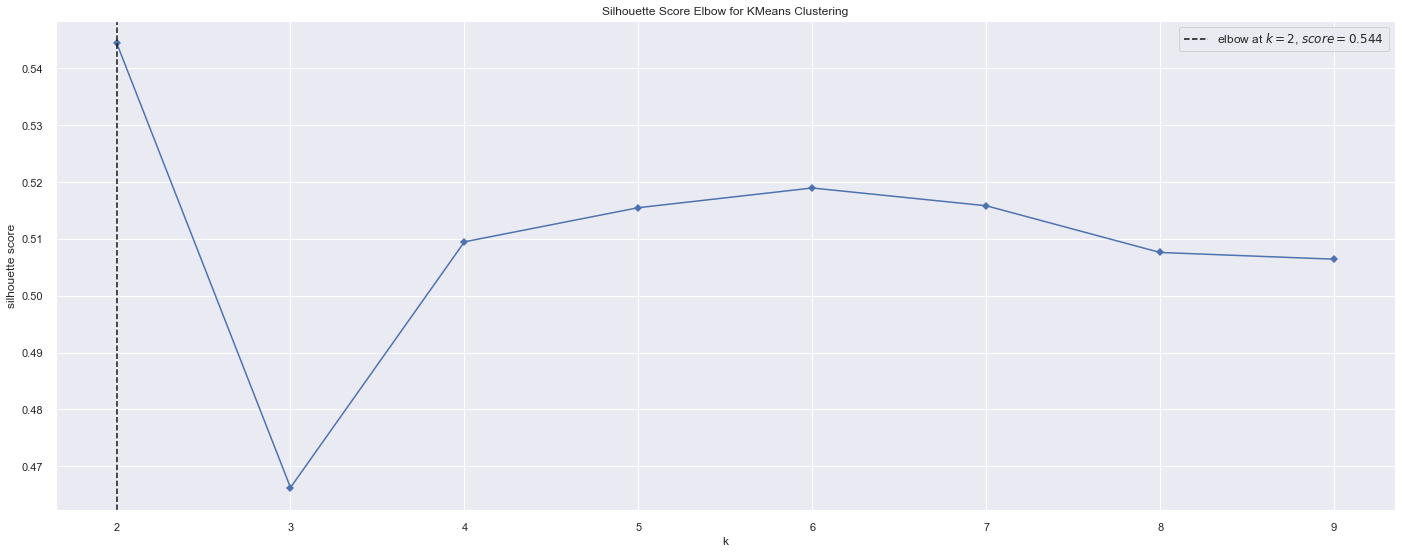

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [55]:
kmeans = KElbowVisualizer(model,k=clusters, metric='silhouette',timings=False,random_state=101)
kmeans.fit(X)
kmeans.show()

### 7.2.1. Silhouette Analysis

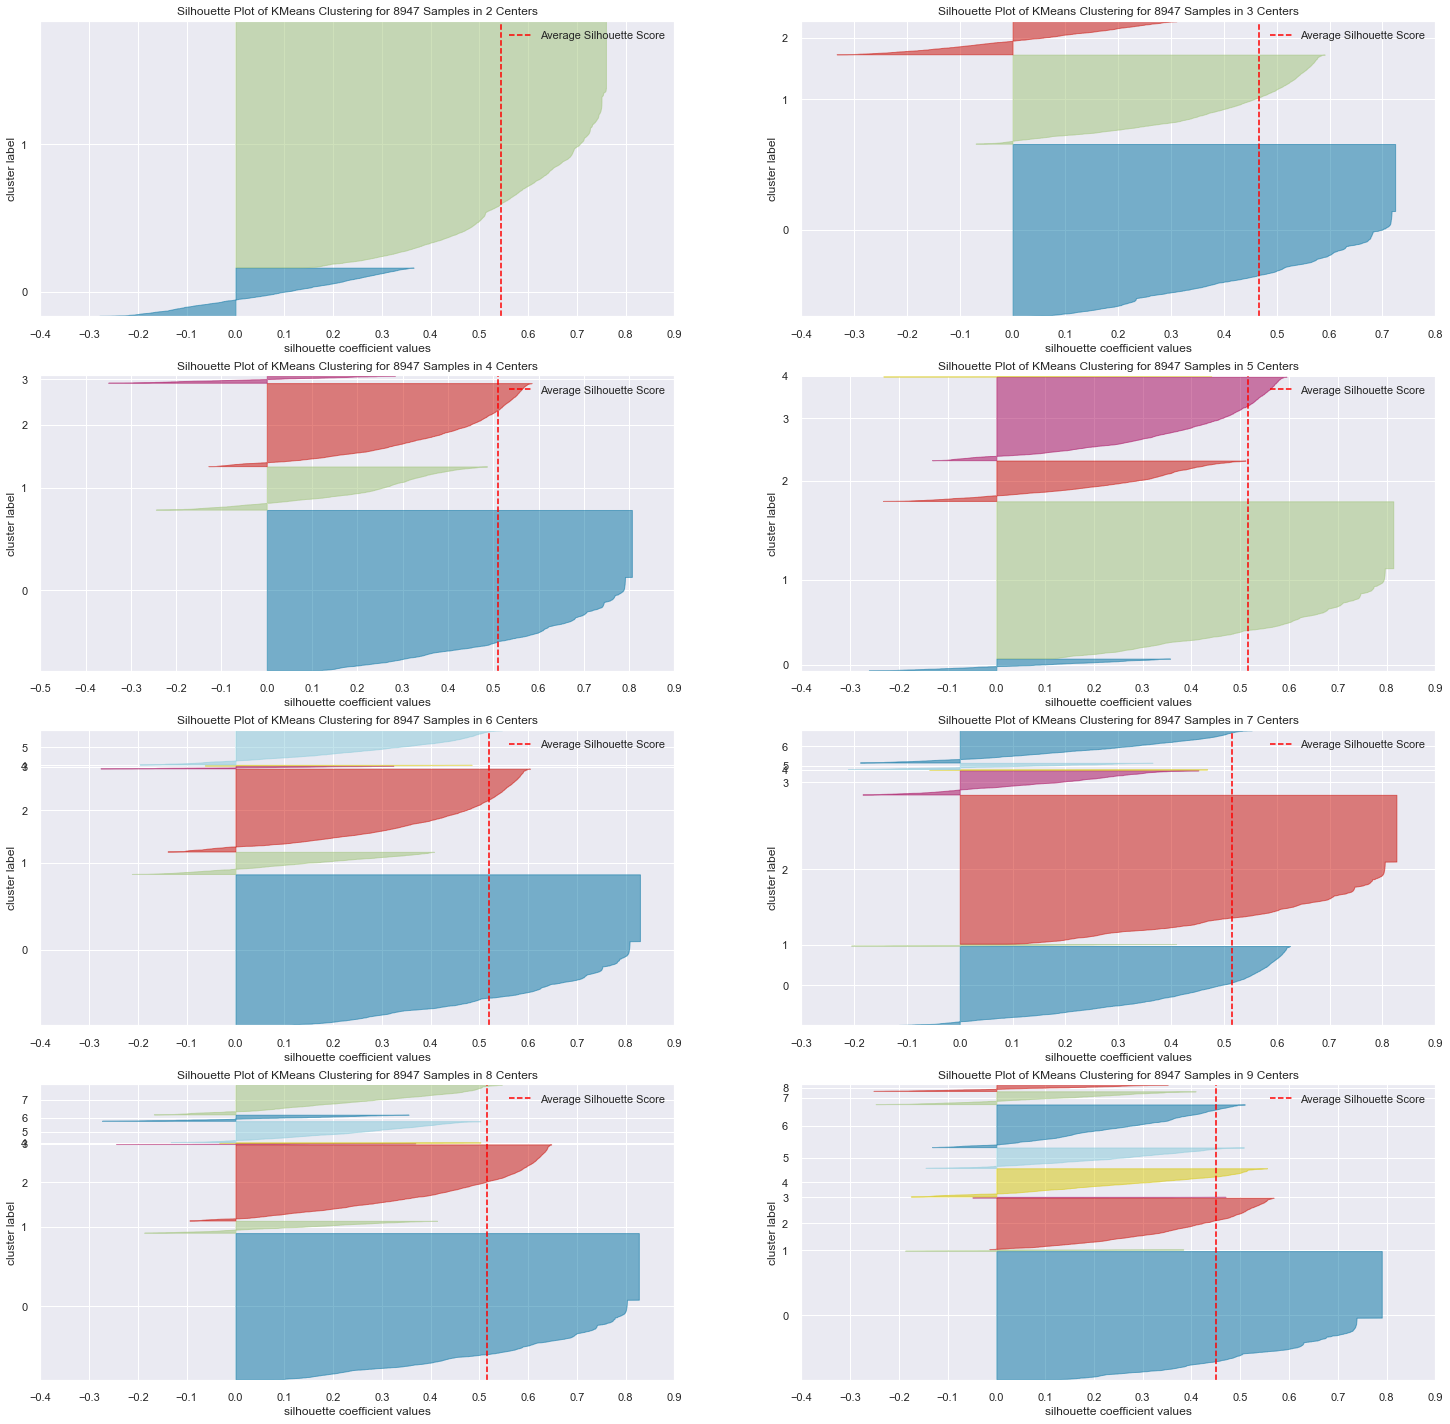

In [58]:
fig, ax = plt.subplots(4,2,figsize=(25,25))

for k in clusters:
  km = KMeans(n_clusters=k,init='random',n_init=10,max_iter=100,random_state=101)
  q, mod = divmod(k,2)

  visualizer = SilhouetteVisualizer(km,colors='yellowbrick',ax=ax[q-1][mod])
  visualizer.fit(X)
  visualizer.finalize()

## 7.3. Davies Bouldin Score

In [62]:
davies_list = []

for k in clusters:
  # model definition
  kmeans_model = KMeans(n_clusters=k,random_state=101)

  # model training
  kmeans_model.fit(X)

  # model predict
  labels = kmeans_model.predict(X)

  # model performance
  dav = m.davies_bouldin_score(X, labels)

  davies_list.append(dav)

Text(0, 0.5, 'Davies Boulding Score')

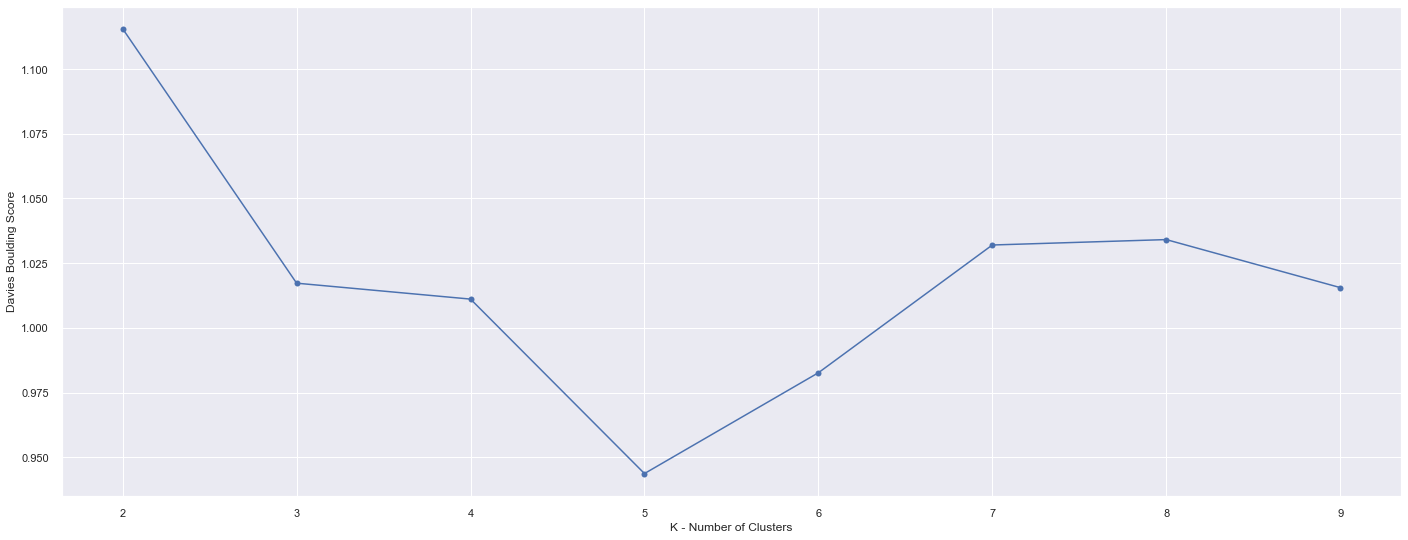

In [63]:
plt.plot(clusters, davies_list,marker='o')
plt.xlabel('K - Number of Clusters')
plt.ylabel('Davies Boulding Score')

# 8. Model Training

## 8.1. K-Means

In [65]:
# Model Definition
k = 6
kmeans = KMeans(init='random',n_clusters=k,random_state=101)

# Model Training
kmeans.fit(X)

# Clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [66]:
# WWS (Within-Cluster Sum of Square)
print('WWS value: {:.2f}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS value: {:.2f}'.format(m.silhouette_score(X,labels)))

# Davies Bouldin Score
print('Davies Boulding Score: {:.2f}'.format(davies_list[1]))

WWS value: 13156.15
SS value: 0.52
Davies Boulding Score: 1.02


# 9. Cluster Analysis

In [67]:
df9 = df3[['cust_id',
           'oneoff_purchases',
           'installments_purchases',
           'oneoff_purchases_frequency',
           'purchases_installments_frequency',
           'purchases_trx']].copy()
df9['cluster'] = labels
df9.head()

,cust_id,oneoff_purchases,installments_purchases,oneoff_purchases_frequency,purchases_installments_frequency,purchases_trx,cluster
0,10001,0.00,95.4,0.000000,0.083333,2,0
1,10002,0.00,0.0,0.000000,0.000000,0,0
2,10003,773.17,0.0,1.000000,0.000000,12,5
3,10004,1499.00,0.0,0.083333,0.000000,1,0
4,10005,16.00,0.0,0.083333,0.000000,1,0


## 9.1. Two-Dimentions Plot

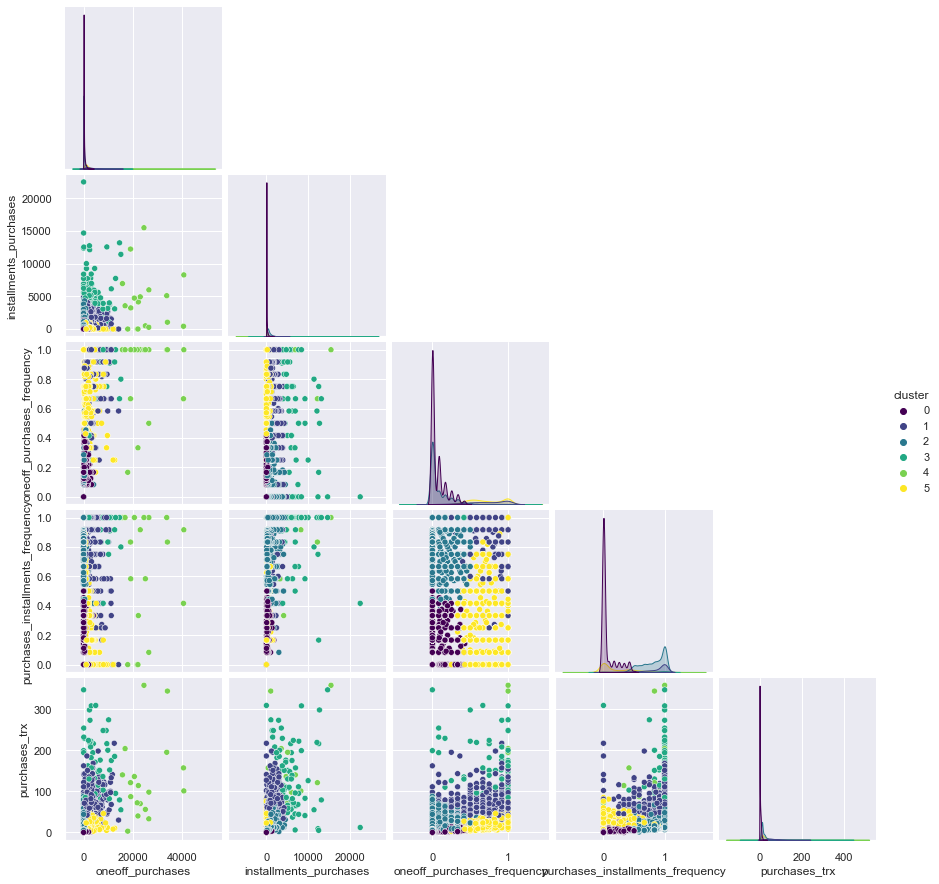

In [69]:
df_viz = df9.drop('cust_id',axis=1)
sns.pairplot(df_viz,hue='cluster',palette='viridis',corner=True)

## 9.2. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

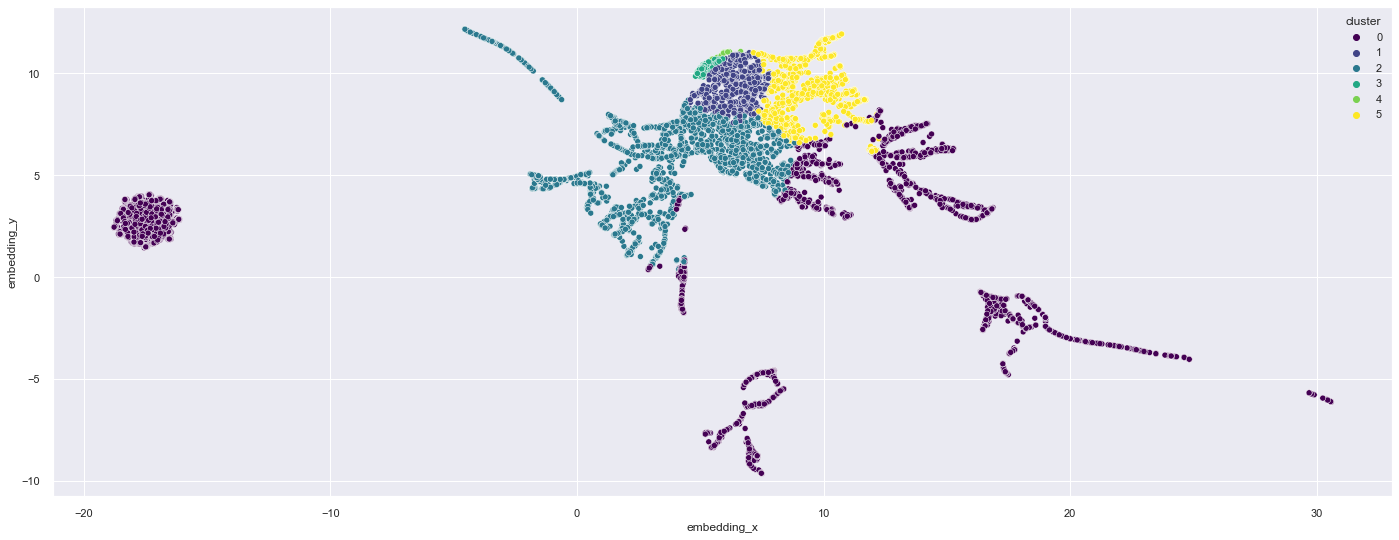

In [76]:
# Quciker from larger datasets but more difficult to visualize
# Change n_neighbors to see something similar to a local structure (\/) ou global structure (/\)
reducer = umap.UMAP(n_neighbors=25,random_state=101)
embedding = reducer.fit_transform(X)

# Embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# Plot UMAP
sns.scatterplot(x='embedding_x',y='embedding_y',data=df_viz,hue='cluster',palette='viridis')

## 9.3. t-SNE

## 9.4. Cluster Profile

In [73]:
df9.columns.tolist()[1:-1]

['oneoff_purchases',
 'installments_purchases',
 'oneoff_purchases_frequency',
 'purchases_installments_frequency',
 'purchases_trx']

In [74]:
df_cluster = df9[['cust_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = round(100*(df_cluster['cust_id']/df_cluster['cust_id'].sum()),2)

for feature in df9.columns.tolist()[1:-1]:
  df_aux = df9[[feature,'cluster']].groupby('cluster').mean().reset_index()
  df_cluster = pd.merge(df_cluster,df_aux, how='inner',on='cluster')

In [57]:
df_cluster

NameError: name 'df_cluster' is not defined

### Cluster 01 *(High OneOff Customers)*
- Number of Customers: **18** (0.2% of customers)
- Total Paid in Cash: **$25,037**
- Total Paid in Installments: **4,270**
- Frequency of Purchases in Cash (from 0 to 1): **0.85** 
- Frequency of Purchases in Installments (from 0 to 1): **0.63** 
- Amount of Purchases: **129**

### Cluster 02 *(High Installments Customers)*
- Number of Customers: **79** (0.88% of customers)
- Total Paid in Cash: **$4,021**
- Total Paid in Installments: **6,124**
- Frequency of Purchases in Cash (from 0 to 1): **0.61** 
- Frequency of Purchases in Installments (from 0 to 1): **0.90** 
- Amount of Purchases: **136**

### Cluster 03 *(Medium Spenders)*
- Number of Customers: **676** (7.56% of customers)
- Total Paid in Cash: **$2,599**
- Total Paid in Installments: **1,434**
- Frequency of Purchases in Cash (from 0 to 1): **0.71** 
- Frequency of Purchases in Installments (from 0 to 1): **0.87** 
- Amount of Purchases: **64**

### Cluster 04 *(Low OneOff Customers)*
- Number of Customers: **1048** (11.71% of customers)
- Total Paid in Cash: **$1,485**
- Total Paid in Installments: **172**
- Frequency of Purchases in Cash (from 0 to 1): **0.71** 
- Frequency of Purchases in Installments (from 0 to 1): **0.20** 
- Amount of Purchases: **20**

### Cluster 05 *(Low Installments Customers)*
- Number of Customers: **2528** (28.26% of customers)
- Total Paid in Cash: **$180**
- Total Paid in Installments: **686**
- Frequency of Purchases in Cash (from 0 to 1): **0.07** 
- Frequency of Purchases in Installments (from 0 to 1): **0.81** 
- Amount of Purchases: **17**

### Cluster 06 *(Leavers)*
- Number of Customers: **4598** (51.39% of customers)
- Total Paid in Cash: **$165**
- Total Paid in Installments: **50**
- Frequency of Purchases in Cash (from 0 to 1): **0.06** 
- Frequency of Purchases in Installments (from 0 to 1): **0.06** 
- Amount of Purchases: **2**

# 10. Deploy to Production